<a href="https://colab.research.google.com/github/JuliaKoryukova/Neural-Networks/blob/main/05_Translating_Encoder_Decoder_RNN_(LSTM%2C_Attention).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='#11a642' size='6'>**Сравнительное обучение разных моделей в задаче перевода**</font>

# Imports

In [ ]:
!pip install spacy

In [ ]:
!pip install torch==2.4.0 torchvision torchaudio torchtext --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.1/799.1 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install nltk

In [ ]:
from typing import List, Tuple, Dict, Union
from pathlib import Path
import random
import time
from tqdm import tqdm
from collections import Counter

from tqdm.notebook import tqdm
from IPython.display import clear_output

from PIL import Image
import numpy as np
import requests
import csv
from collections import defaultdict

import math

from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import torch.nn.functional as F
import torch.optim as optim
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu

import torchvision
from torchvision.utils import make_grid
from torch.nn.utils.rnn import pad_sequence
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset
from torch.amp import GradScaler, autocast
from torchvision.models import MobileNet_V2_Weights
from torchvision.transforms import v2
from torchtext.vocab import build_vocab_from_iterator
from torchtext.vocab import Vocab

import seaborn as sns
import spacy
from sklearn.model_selection import train_test_split

import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction


import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [ ]:
!pip list | grep -P 'torch|spacy'

spacy                              3.7.5
spacy-legacy                       3.0.12
spacy-loggers                      1.0.5
torch                              2.4.0+cu121
torchaudio                         2.4.0+cu121
torchsummary                       1.5.1
torchtext                          0.6.0
torchvision                        0.19.0+cu121


In [ ]:
# функция если нужно зафиксировать все сиды для воспроизводимости
# (cudnn.deterministic = True может немного замедлить работу GPU)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def seed(value: int = 111) -> None:
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.cuda.manual_seed_all(value)
    np.random.seed(value)
    random.seed(value)

# 1. Подготовка данных

## Загрузка датасета португальский - английский

In [ ]:
# Загрузка датасета
!wget https://www.manythings.org/anki/por-eng.zip

--2024-11-16 20:08:20--  https://www.manythings.org/anki/por-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6494486 (6.2M) [application/zip]
Saving to: ‘por-eng.zip’

por-eng.zip         100%[===================>]   6.19M  17.9MB/s    in 0.3s    

2024-11-16 20:08:21 (17.9 MB/s) - ‘por-eng.zip’ saved [6494486/6494486]



In [ ]:
!unzip por-eng.zip

Archive:  por-eng.zip
  inflating: _about.txt              
  inflating: por.txt                 


In [ ]:
!head -n 5 por.txt

Go.	Vai.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1196331 (alexmarcelo)
Go.	Vá.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5464111 (ToinhoAlam)
Hi.	Oi.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #397074 (brauliobezerra)
Run!	Corre!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1197457 (alexmarcelo)
Run!	Corra!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1197458 (alexmarcelo)


## Чтение и очистка датасета от метаданных

In [ ]:
# Чтение датасета
dataset_path = 'por.txt'

# Чтение файла и очистка метаданных
pairs = []
with open(dataset_path, 'r', encoding='utf-8') as file:
    for line in file:
        # Разделение строки по табуляции
        parts = line.split('\t')
        if len(parts) >= 2: # нужно убедиться, что как минимум два предложения есть
            en_sent = parts[0].lower().strip()
            por_sent = parts[1].lower().strip()
            pairs.append((en_sent, por_sent))

# Первые 5 пар
for en, por in pairs[:5]:
    print(f'English: {en}\nPortuguese: {por}\n')

English: go.
Portuguese: vai.

English: go.
Portuguese: vá.

English: hi.
Portuguese: oi.

English: run!
Portuguese: corre!

English: run!
Portuguese: corra!



## Токенизация и создание словаря

In [ ]:
# Загрузка языковых моделей
%%capture
!python -m spacy download en_core_web_sm
!python -m spacy download pt_core_news_sm

In [ ]:
# Загрузка моделей для английского и погтугальского языков
nlp_en = spacy.load("en_core_web_sm")
nlp_por = spacy.load("pt_core_news_sm")

# Функции токенизации для каждого языка
def en_tokenizer(sentence):
    return [token.text for token in nlp_en(sentence)]

def por_tokenizer(sentence):
    return [token.text for token in nlp_por(sentence)]

# Функция для токенизации предложений
def tokenize_sentences(sentences):
    tokenized_pairs = []
    for en_sentence, por_sentence in tqdm(sentences, desc="Токенизация предложений"):
        en_tokens = en_tokenizer(en_sentence)  # Токенизация английского предложения
        por_tokens = por_tokenizer(por_sentence)  # Токенизация португальского предложения
        tokenized_pairs.append((en_tokens, por_tokens))  # Добавление токенов в список
    return tokenized_pairs

In [ ]:
# Сохранение токенов в CSV файл
def save_tokens_to_csv(token_file, tokenized_pairs):
    with open(token_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['src', 'trg'])
        for src_tokens, trg_tokens in tokenized_pairs:
            writer.writerow([' '.join(map(str, src_tokens)), ' '.join(map(str, trg_tokens))])

# Загрузка токенизированных данных из CSV файла
def load_tokenized_pairs_from_csv(token_file):
    tokenized_pairs = []
    with open(token_file, newline='') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            src_tokens = row[0].split()
            trg_tokens = row[1].split()
            tokenized_pairs.append((src_tokens, trg_tokens))
    return tokenized_pairs

In [ ]:
# Применение токенизации к первым 5 парам предложений
tokenized_sentences = tokenize_sentences(pairs[:5])

# Вывод токенизированных предложений
for en_tokens, por_tokens in tokenized_sentences:
    print("English tokens:", en_tokens)
    print("Portuguese tokens:", por_tokens)
    print()

Токенизация предложений:   0%|          | 0/5 [00:00<?, ?it/s]

English tokens: ['go', '.']
Portuguese tokens: ['vai', '.']

English tokens: ['go', '.']
Portuguese tokens: ['vá', '.']

English tokens: ['hi', '.']
Portuguese tokens: ['oi', '.']

English tokens: ['run', '!']
Portuguese tokens: ['corre', '!']

English tokens: ['run', '!']
Portuguese tokens: ['corra', '!']



In [ ]:
# # Собрать все токены из предложений с индикатором прогресса
# counter_input = Counter()
# counter_target = Counter()

# # Токенизация с отображением прогресса
# print("Сбор токенов для английского языка...")
# for src, _ in tqdm(pairs, desc="Processing English sentences"):
#     tokens = en_tokenizer(src)
#     counter_input.update(tokens)

# print("Сбор токенов для португальского языка...")
# for _, trg in tqdm(pairs, desc="Processing Portuguese sentences"):
#     tokens = por_tokenizer(trg)
#     counter_target.update(tokens)

# print("Сбор токенов завершен.")

In [ ]:
# # Сохранение токенов в CSV файл
# def save_counter_to_csv(counter, filename):
#     with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(['Token', 'Frequency'])  # Заголовок
#         for token, freq in counter.items():
#             writer.writerow([token, freq])

# # 3. Сохранение токенов для обоих языков
# save_counter_to_csv(counter_input, 'english_tokens.csv')
# save_counter_to_csv(counter_target, 'portuguese_tokens.csv')

# print("Токены сохранены в файлы english_tokens.csv и portuguese_tokens.csv")

In [ ]:
# Функция для чтения CSV файла и обновления счётчика токенов
def read_csv_and_update_counter(filename, counter):
    with open(filename, 'r', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Пропустить заголовок
        for row in reader:
            token, frequency = row
            counter[token] += int(frequency)

# Чтение и обновление счётчиков для английских и португальских токенов
counter_input = Counter()  # Для английских токенов
counter_target = Counter()  # Для португальских токенов

# Обновляем счётчики с данными из CSV файлов
read_csv_and_update_counter('english_tokens.csv', counter_input)
read_csv_and_update_counter('portuguese_tokens.csv', counter_target)

# Проверка сохранённых данных
print(f"Количество уникальных токенов в английском словаре: {len(counter_input)}")
print(f"Количество уникальных токенов в португальском словаре: {len(counter_target)}")

# Выводим топ-10 токенов для каждого языка
print(f"Топ-10 токенов в английском словаре: {counter_input.most_common(10)}")
print(f"Топ-10 токенов в португальском словаре: {counter_target.most_common(10)}")

Количество уникальных токенов в английском словаре: 13245
Количество уникальных токенов в португальском словаре: 23996
Топ-10 токенов в английском словаре: [('.', 161703), ('i', 64480), ('tom', 53512), ('you', 44981), ('to', 44275), ('the', 34614), ('?', 32291), ("n't", 31237), ('do', 26290), ('is', 24424)]
Топ-10 токенов в португальском словаре: [('.', 160533), ('tom', 53336), ('que', 44689), ('o', 40872), ('não', 38743), ('eu', 35884), ('?', 32445), ('de', 29817), ('a', 26708), ('você', 26386)]


In [ ]:
# Спец символы: неизвестный, паддинг, начало и конец предложения
specials = ['<unk>', '<pad>', '<bos>', '<eos>']

# Создаем словари для слов, которые встречаются в тексте более min_freq раз
# specials - просто атрибут словаря, их индексы будут идти по порядку [0, 1, 2, 3]
en_vocab = Vocab(counter_input, min_freq=1, specials=specials)
por_vocab = Vocab(counter_target, min_freq=1, specials=specials)

# Устанавливаем индекс для неизвестных слов (заменяем на <unk>)
unk_index_en = en_vocab['<unk>']
unk_index_por = por_vocab['<unk>']

# Словари из индекса в слово для декодирования
# index_to_word_en = {v: k for k, v in en_vocab.stoi.items()}
# index_to_word_por = {v: k for k, v in por_vocab.stoi.items()}

index_to_word_en = {index: token for token, index in zip(en_vocab.itos, range(len(en_vocab)))}
index_to_word_por = {index: token for token, index in zip(por_vocab.itos, range(len(por_vocab)))}

# Проверка на наличие
print(f"Размер словаря английского: {len(index_to_word_en)}")
print(f"Размер словаря португальского: {len(index_to_word_por)}")

# Функция для создания маппинга токенов в индексы с использованием defaultdict
def create_vocab_mapping(vocab, unk_index):
    return defaultdict(lambda: unk_index, vocab)

# Создаем маппинги для английского и португальского словарей
vocab_mapping_en = create_vocab_mapping(en_vocab.stoi, unk_index_en)
vocab_mapping_por = create_vocab_mapping(por_vocab.stoi, unk_index_por)

# Функция для преобразования списка токенов в индексы с использованием маппинга
def tokens_to_indices_fast(tokens, vocab_mapping):
    return [vocab_mapping[token] for token in tqdm(tokens, desc="Преобразование токенов")]

# Пример списка токенов (тестовый)
tokens = ['hello', 'world', 'unknown_word', '!', 'run'] * 1000  # Пример большого списка токенов

# Преобразуем список токенов в индексы
token_indices = tokens_to_indices_fast(tokens, vocab_mapping_en)

# Выводим первые 10 индексов
print(token_indices[:10])

Размер словаря английского: 13249
Размер словаря португальского: 24000


Преобразование токенов:   0%|          | 0/5000 [00:00<?, ?it/s]

[1552, 428, 0, 157, 473, 1552, 428, 0, 157, 473]


In [ ]:
print(en_vocab.itos)
print(por_vocab.itos)

['<unk>', '<pad>', '<bos>', '<eos>', '.', 'i', 'tom', 'you', 'to', 'the', '?', "n't", 'do', 'is', 'a', 'that', "'s", 'it', 'was', 'in', 'he', 'we', 'have', 'me', 'did', 'this', 'of', ',', 'what', 'my', 'are', "'m", 'mary', 'know', 'for', 'be', 'want', 'like', 'your', 'with', "'re", 'on', 'think', 'not', 'and', 'can', 'his', 'go', 'how', "'ll", 'at', 'here', 'there', 'does', 'has', "'ve", 'they', 'going', 'she', 'very', 'why', 'about', 'will', 'time', 'all', 'would', 'one', 'were', 'need', 'who', 'as', 'get', 'ca', 'boston', 'had', 'should', 'french', 'said', 'him', 'where', 'when', 'if', 'up', 'help', 'out', "'d", 'could', 'tell', 'us', 'no', 'good', 'an', 'let', 'been', 'from', 'see', 'by', 'never', 'just', 'come', 'than', 'her', 'now', 'told', 'still', 'really', 'so', 'doing', 'much', 'got', 'please', 'more', 'something', 'home', 'too', 'wo', 'car', 'lot', 'back', 'some', 'wanted', 'anything', '"', 'work', 'three', 'today', 'take', 'last', 'people', 'but', 'many', 'day', 'talk', 'rig

In [ ]:
# Установка переменных для токенайзеров и словарей
inp_tokenizer = en_tokenizer  # Токенайзер для английского языка
trg_tokenizer = por_tokenizer  # Токенайзер для португальского языка

inp_vocab = en_vocab
trg_vocab = por_vocab

# Индексы специальных токенов
PAD_INDEX = inp_vocab['<pad>']
BOS_INDEX = inp_vocab['<bos>']
EOS_INDEX = inp_vocab['<eos>']

index_to_word_inp = index_to_word_en
index_to_word_trg = index_to_word_por

# Функция для кодирования текста в индексы
def encode(text, tokenizer, vocab):
    tokens = [vocab[token] if token in vocab.stoi else vocab['<unk>'] for token in tokenizer(text)]
    return torch.tensor([vocab['<bos>']] + tokens + [vocab['<eos>']])

# Функция для декодирования индексов обратно в текст
def decode(tokens, vocab):
    return ' '.join([vocab.itos[token] if token < len(vocab.itos) else '<unk>' for token in tokens])

# Функция для преобразования пары предложений в тензоры
def tensors_from_pair(pair):
    input_tensor = encode(pair[0], inp_tokenizer, inp_vocab)
    target_tensor = encode(pair[1], trg_tokenizer, trg_vocab)

    # Используем clone().detach() и указываем тип тензора
    input_tensor = input_tensor.clone().detach().long()
    target_tensor = target_tensor.clone().detach().long()

    return input_tensor, target_tensor

# Пример использования
example_pair = ('go.', 'vai.')  # Пример пары предложений
input_tensor, target_tensor = tensors_from_pair(example_pair)

print(f"Input tensor: {input_tensor}")
print(f"Target tensor: {target_tensor}")

Input tensor: tensor([ 2, 47,  4,  3])
Target tensor: tensor([ 2, 48,  4,  3])


In [ ]:
# Пример работы токенизаторов и словарей
for src, trg in pairs[:5]:  # Первые 5 пар
    # Кодирование
    encoded_src = encode(src, inp_tokenizer, inp_vocab)
    encoded_trg = encode(trg, trg_tokenizer, trg_vocab)

    print("Encoded Source:", encoded_src)
    print("Encoded Target:", encoded_trg)

    # Декодирование обратно в текст
    decoded_src = decode(encoded_src, inp_vocab)
    decoded_trg = decode(encoded_trg, trg_vocab)

    print("Decoded Source:", decoded_src)
    print("Decoded Target:", decoded_trg)
    print('-' * 40)

# Проверка наличия конкретных слов в словарях
print('Index of "go" in inp_vocab:', inp_vocab.stoi.get('go', '<not found>'))
print('Index of "vai" in trg_vocab:', trg_vocab.stoi.get('vai', '<not found>'))

Encoded Source: tensor([ 2, 47,  4,  3])
Encoded Target: tensor([ 2, 48,  4,  3])
Decoded Source: <bos> go . <eos>
Decoded Target: <bos> vai . <eos>
----------------------------------------
Encoded Source: tensor([ 2, 47,  4,  3])
Encoded Target: tensor([  2, 330,   4,   3])
Decoded Source: <bos> go . <eos>
Decoded Target: <bos> vá . <eos>
----------------------------------------
Encoded Source: tensor([   2, 2191,    4,    3])
Encoded Target: tensor([   2, 2246,    4,    3])
Decoded Source: <bos> hi . <eos>
Decoded Target: <bos> oi . <eos>
----------------------------------------
Encoded Source: tensor([  2, 473, 157,   3])
Encoded Target: tensor([   2, 1748,   91,    3])
Decoded Source: <bos> run ! <eos>
Decoded Target: <bos> corre ! <eos>
----------------------------------------
Encoded Source: tensor([  2, 473, 157,   3])
Encoded Target: tensor([   2, 2922,   91,    3])
Decoded Source: <bos> run ! <eos>
Decoded Target: <bos> corra ! <eos>
----------------------------------------
In

## Проверка сбалансированности данных

Проверка длины предложений

In [ ]:
# Пакетная токенизация с прогрессом
def batch_tokenize_length(nlp, sentences, batch_size=1000):
    docs = nlp.pipe(sentences, batch_size=batch_size)
    return [len([token.text for token in doc]) for doc in tqdm(docs, total=len(sentences), desc="Токенизация")]

# Функция для проверки длины предложений с пакетной токенизацией
def sentence_lengths_batch(pairs):
    en_sentences = [en for en, _ in pairs]  # Английские предложения
    por_sentences = [por for _, por in pairs]  # Португальские предложения

    print("Токенизация английских предложений для подсчета длины...")
    en_lengths = batch_tokenize_length(nlp_en, en_sentences)  # Пакетная токенизация для английских предложений

    print("Токенизация поргутальских предложений для подсчета длины...")
    por_lengths = batch_tokenize_length(nlp_por, por_sentences)  # Пакетная токенизация для португальских предложений

    return en_lengths, por_lengths

en_lengths, por_lengths = sentence_lengths_batch(pairs)

Токенизация английских предложений для подсчета длины...


Токенизация:   0%|          | 0/193633 [00:00<?, ?it/s]

Токенизация поргутальских предложений для подсчета длины...


Токенизация:   0%|          | 0/193633 [00:00<?, ?it/s]

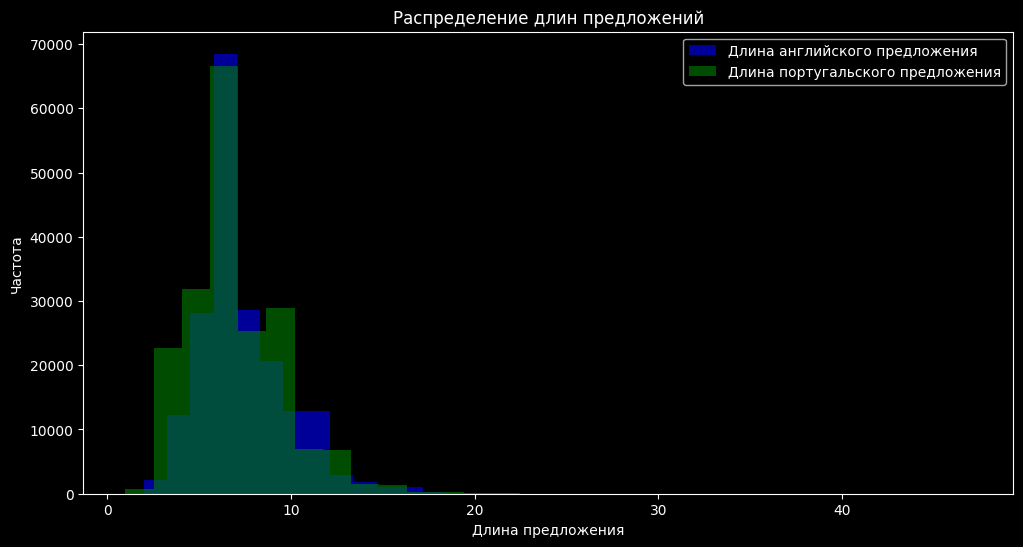

In [ ]:
# Визуализация длины предложений
plt.figure(figsize=(12, 6))
plt.hist(en_lengths, bins=30, alpha=0.6, color='blue', label='Длина английского предложения')
plt.hist(por_lengths, bins=30, alpha=0.6, color='green', label='Длина португальского предложения')
plt.title('Распределение длин предложений')
plt.xlabel('Длина предложения')
plt.ylabel('Частота')
plt.legend()
plt.show()

Проверка распределения частоты слов

In [ ]:
# Функция распределения частоты слов
def plot_word_distribution(counter, language):
    words, counts = zip(*counter.most_common(30))  # Берём 30 самых частых слов
    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Частота')
    plt.title(f'Топ-30 самых частых слов ({language})')
    plt.gca().invert_yaxis()  # Чтобы самые частые слова были наверху
    plt.show()

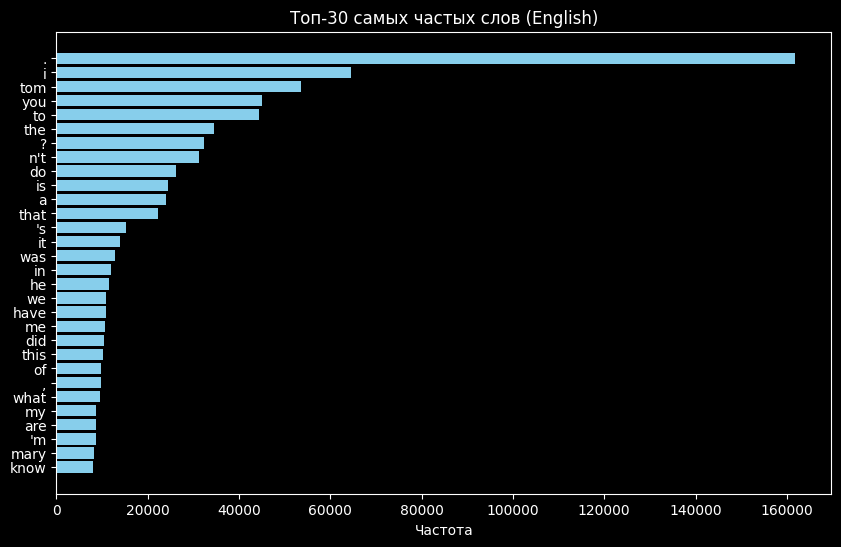

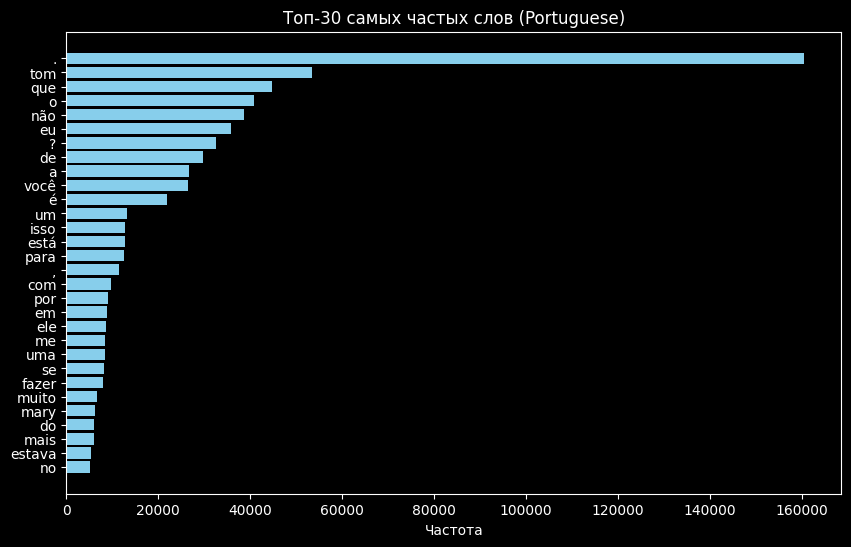

In [ ]:
# Визуализация распределения частоты слов
plot_word_distribution(counter_input, 'English')
plot_word_distribution(counter_target, 'Portuguese')

Статистика по количеству уникальных слов

In [ ]:
print(f'Уникальных слов в английском: {len(inp_vocab)}')
print(f'Уникальных слов в португальском: {len(trg_vocab)}')

Уникальных слов в английском: 13249
Уникальных слов в португальском: 24000


Средняя длина предложений

In [ ]:
print(f'Средняя длина английских предложений: {sum(en_lengths)/len(en_lengths):.2f}')
print(f'Средняя длина португальских предложений: {sum(por_lengths)/len(por_lengths):.2f}')

Средняя длина английских предложений: 7.45
Средняя длина португальских предложений: 7.08


## Разделение данных на обучающую и тестовую выборки

In [ ]:
# # Разделение данных на обучающую и тестовую выборки
# train_pairs, test_pairs = train_test_split(pairs, test_size=0.2, random_state=42)

In [ ]:
# collate_batch определяет, что делать с батчом при итерации по лоадеру
def collate_batch(batch):
    src_list, trg_list = [], []

    # Итерация по batch - списку пар строк (src, trg)
    for src, trg in batch:
        # Превратить строки в индексы токенов с добавлением спец символов <bos> и <eos>
        src_encoded = encode(src, inp_tokenizer, inp_vocab)
        trg_encoded = encode(trg, trg_tokenizer, trg_vocab)

        # Добавить закодированные предложения как тензоры в списки
        src_list.append(src_encoded.clone().detach().long())
        trg_list.append(trg_encoded.clone().detach().long())

    # Паддинг, чтобы длина каждой последовательности была одинаковой (batch_first=True)
    src_padded = pad_sequence(src_list, padding_value=inp_vocab['<pad>'], batch_first=True)
    trg_padded = pad_sequence(trg_list, padding_value=trg_vocab['<pad>'], batch_first=True)

    return src_padded, trg_padded


# Размер батча (сколько предложений в батче)
BATCH_SIZE = 8

# Разделение данных на обучающую и валидационную части
val_size = int(len(pairs) * 0.2)  # 20% на валидацию
train_pairs = pairs[:-val_size]
val_pairs = pairs[-val_size:]

# DataLoader для тренировочной и валидационной выборки
train_dataloader = DataLoader(train_pairs, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_pairs, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

# Пример извлечения батча из train_dataloader
for src_batch, trg_batch in train_dataloader:
    print(f"Source batch shape: {src_batch.shape}")
    print(f"Target batch shape: {trg_batch.shape}")
    break  # Прерываем после первого батча для примера

Source batch shape: torch.Size([8, 12])
Target batch shape: torch.Size([8, 9])


In [ ]:
# проверка что отдает лоадер
# Получаем первый батч из тренировочного DataLoader
src_batch, trg_batch = next(iter(train_dataloader))

# Выводим размеры (shape) батчей
print("Shape of source batch (src_batch):", src_batch.shape)
print("Shape of target batch (trg_batch):", trg_batch.shape)

Shape of source batch (src_batch): torch.Size([8, 11])
Shape of target batch (trg_batch): torch.Size([8, 10])


In [ ]:
def decode_predictions(pred_indices, index_to_word):
    # Создание предложения из индексов
    sentence = [
        index_to_word[idx]
        for idx in pred_indices
        if idx not in (PAD_INDEX, BOS_INDEX, EOS_INDEX)  # Удален вызов .item()
    ]
    return ' '.join(sentence)

In [ ]:
# Декодирование из индексов токенов в слова строки
decoded_src = decode_predictions(src_batch[0, :].tolist(), index_to_word_inp)
decoded_trg = decode_predictions(trg_batch[0, :].tolist(), index_to_word_trg)

print("Decoded Source:", decoded_src)
print('--------------------------')
print("Decoded Target:", decoded_trg)

Decoded Source: i just want out of here .
--------------------------
Decoded Target: eu só quero sair daqui .


# 2. Обучение моделей

## Модель EncoderDecoderRNN c LSTM

In [ ]:
def tensors_from_pair(pair):
    input_tensor = torch.tensor([inp_vocab[word] for word in pair[0].split()], dtype=torch.long)
    target_tensor = torch.tensor([trg_vocab[word] for word in pair[1].split()], dtype=torch.long)

    # Паддинг входного тензора
    input_tensor = input_tensor.unsqueeze(1)  # Добавим размерность
    input_tensor = pad_sequence([input_tensor], batch_first=True)

    input_tensor = input_tensor.view(-1, 1)  # длина последовательности, 1

    return input_tensor, target_tensor

Создание модели

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)  # Формируем embedded тензор
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size),
                torch.zeros(self.num_layers, 1, self.hidden_size))

In [ ]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, dropout_p=0.1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)  # (1, 1, hidden_size)
        embedded = self.dropout(embedded)

        output, hidden = self.lstm(embedded, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)  # (1, output_size)
        return output, hidden

Обучение модели

In [ ]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=50):
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = min(input_tensor.size(0), max_length)
    target_length = min(target_tensor.size(0), max_length)

    loss = 0

    # Encoder forward pass
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

    # Decoder forward pass
    decoder_input = torch.tensor([[inp_vocab['<bos>']]])
    decoder_hidden = encoder_hidden

    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()

        loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
        if decoder_input.item() == trg_vocab['<eos>']:
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

Оценка модели

In [ ]:
def evaluate_bleu(encoder, decoder, pairs, n_samples=10):
    references = []
    hypotheses = []

    for _ in range(n_samples):
        pair = random.choice(pairs)
        input_tensor, target_tensor = tensors_from_pair(pair)

        # Получение перевода
        output_sentence = evaluate(encoder, decoder, input_tensor)

        # Преобразуем target_tensor обратно в предложение
        target_sentence = ' '.join([trg_vocab.itos[token] for token in target_tensor.view(-1).tolist() if token != EOS_INDEX])

        references.append([target_sentence.split()])
        hypotheses.append(output_sentence.split())

    # Функция сглаживания для BLEU
    smoothing_function = SmoothingFunction().method1

    # Вычисление BLEU с использованием сглаживания
    bleu_scores = [sentence_bleu(ref, hyp, smoothing_function=smoothing_function) for ref, hyp in zip(references, hypotheses)]

    return sum(bleu_scores) / len(bleu_scores)

Предсказание и декодирование

In [ ]:
# Предсказание и декодирование
def evaluate(encoder, decoder, input_tensor, max_length=50):
    with torch.no_grad():
        input_length = min(input_tensor.size(0), max_length)
        encoder_hidden = encoder.init_hidden()

        # Пропускаем входное предложение через кодировщик
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

        # Начальное слово для декодера — токен начала предложения (BOS)
        decoder_input = torch.tensor([[inp_vocab['<bos>']]])
        decoder_hidden = encoder_hidden

        decoded_words = []
        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            if topi.item() == trg_vocab['<eos>']:
                decoded_words.append('<eos>')
                break
            else:
                decoded_words.append(trg_vocab.itos[topi.item()])

            decoder_input = topi.squeeze().detach()

        return ' '.join(decoded_words)

In [ ]:
def train_and_evaluate(encoder, decoder, pairs, n_iters, learning_rate, print_every=1000, evaluate_every=1000):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab['<pad>'])

    total_loss = 0
    total_bleu = 0
    losses = []
    bleu_scores = []
    times = []  # Список для хранения времени только на тех итерациях, где записываются потери
    progress_bar = tqdm(range(1, n_iters + 1), desc="Обучение")

    overall_start_time = time.time()  # Начало отсчета времени для всего процесса обучения

    for iter in progress_bar:
        iter_start_time = time.time()

        # Выбор случайной пары предложений
        pair = random.choice(pairs)
        input_tensor, target_tensor = tensors_from_pair(pair)

        # Обучение модели
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        total_loss += loss

        # Периодическая оценка BLEU
        if iter % evaluate_every == 0:
            bleu_score = evaluate_bleu(encoder, decoder, pairs, n_samples=10)
            total_bleu += bleu_score
            bleu_scores.append(bleu_score)

        # Обновляем потери и время только каждые print_every итераций
        if iter % print_every == 0:
            avg_loss = total_loss / print_every
            avg_bleu = total_bleu / (print_every // evaluate_every)
            print(f"Итерация {iter}, Средняя потеря: {avg_loss:.4f}, Средний BLEU: {avg_bleu:.4f}")

            losses.append(avg_loss)
            total_loss = 0
            total_bleu = 0

            # Записываем текущее время для итерации, кратной print_every
            current_time = time.time() - overall_start_time
            times.append(current_time)  # Сохраняем время только для этих итераций

    overall_elapsed_time = time.time() - overall_start_time  # Общее время обучения
    print(f"Общее время обучения: {overall_elapsed_time:.2f} секунд")

    return encoder, decoder, losses, bleu_scores, times

Запуск обучения

In [ ]:
hidden_size = 128
num_layers = 1

# Создание экземпляров кодировщика и декодера
encoder = Encoder(input_size=len(inp_vocab), hidden_size=hidden_size, num_layers=num_layers)
decoder = Decoder(hidden_size=hidden_size, output_size=len(trg_vocab), num_layers=num_layers)

# Параметры обучения
n_iters = 10000
learning_rate = 0.001

# Запуск цикла обучения и оценки
encoder, decoder, losses, bleu, times = train_and_evaluate(encoder, decoder, train_pairs, n_iters, learning_rate)

Обучение:   0%|          | 0/10000 [00:00<?, ?it/s]

Итерация 1000, Средняя потеря: 5.5903, Средний BLEU: 0.0039
Итерация 2000, Средняя потеря: 4.8335, Средний BLEU: 0.0047
Итерация 3000, Средняя потеря: 4.5929, Средний BLEU: 0.0050
Итерация 4000, Средняя потеря: 4.4454, Средний BLEU: 0.0046
Итерация 5000, Средняя потеря: 4.3334, Средний BLEU: 0.0051
Итерация 6000, Средняя потеря: 4.2132, Средний BLEU: 0.0052
Итерация 7000, Средняя потеря: 4.0851, Средний BLEU: 0.0077
Итерация 8000, Средняя потеря: 4.0680, Средний BLEU: 0.0054
Итерация 9000, Средняя потеря: 4.0514, Средний BLEU: 0.0051
Итерация 10000, Средняя потеря: 3.9441, Средний BLEU: 0.0053
Общее время обучения: 2089.64 секунд


In [ ]:
# Вывод предсказанного предложения для проверки
for i in range(5):  # Например, 5 предложений
    pair = random.choice(pairs)
    input_tensor, target_tensor = tensors_from_pair(pair)
    output_sentence = evaluate(encoder, decoder, input_tensor)
    print(f"Исходное: {pair[0]}")
    print(f"Целевое: {pair[1]}")
    print(f"Предсказанное: {output_sentence}")
    print('--------------------------')

Исходное: tom must be very tired.
Целевое: tom deve estar muito cansado.
Предсказанное: tom tom <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
--------------------------
Исходное: should i help tom with his homework?
Целевое: devo ajudar o tom com o trabalho de casa dele?
Предсказанное: o que o que o <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
--------------------------
Исходное: so you are really offering me a roflex watch for 5 dollars?
Целевое: então você está realmente me propondo um relógio roflex por 5 dólares?
Предсказан

In [ ]:
print("Final Times shape:", times[-1])
print("Final Losses shape:", losses[-1])

Final Times shape: 2089.634027004242
Final Losses shape: 3.944065714621546


In [ ]:
# Сохранение модели (архитектура + параметры)
torch.save(encoder, 'encoder_full.pth')
torch.save(decoder, 'decoder_full.pth')

In [ ]:
# Загрузка целой модели
encoder = torch.load('encoder_full.pth')
decoder = torch.load('decoder_full.pth')

# Устанавливаем режим оценки
encoder.eval()
decoder.eval()

<ipython-input-54-3a464b0a09c8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load('encoder_full.pth')
<ipython-input-54-3a464b0a09c8>:3: FutureWarning: Y

DecoderWithAttention(
  (embedding): Embedding(24000, 128)
  (attn): Attention(
    (attn): Linear(in_features=256, out_features=128, bias=True)
  )
  (attn_combine): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(128, 128)
  (out): Linear(in_features=128, out_features=24000, bias=True)
)

## Модель EncoderDecoderRNN with Attention

Создание модели

In [ ]:
# Attention
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        hidden = hidden[0].repeat(max_len, 1, 1).transpose(0, 1)
        attn_energies = self.score(hidden, encoder_outputs)
        return F.softmax(attn_energies, dim=1)

    def score(self, hidden, encoder_outputs):
        if encoder_outputs.dim() == 2:
            encoder_outputs = encoder_outputs.unsqueeze(0)

        if hidden.dim() == 2:
            hidden = hidden.unsqueeze(1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), 2)))
        energy = energy.transpose(1, 2)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

In [ ]:
# Encoder with Attention
class EncoderWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(EncoderWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size),
                torch.zeros(self.num_layers, 1, self.hidden_size))

In [ ]:
# Dencoder with Attention
class DecoderWithAttention(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=2, dropout_p=0.1, max_length=10):
        super(DecoderWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attn = Attention(hidden_size)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        attn_weights = self.attn(hidden, encoder_outputs[:self.max_length])
        encoder_outputs = encoder_outputs.unsqueeze(0)
        attn_weights = attn_weights.unsqueeze(1)  # Размерность (1, 1, max_length)
        context = torch.bmm(attn_weights, encoder_outputs)  # Размерность (1, 1, hidden_size)
        output = torch.cat((embedded, context), 2)  # Размерность: (1, 1, hidden_size * 2)
        output = self.attn_combine(output)  # Размерность: (1, 1, hidden_size)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)  # Выход: (1, 1, hidden_size)
        output = F.log_softmax(self.out(output[0]), dim=1)  # Размерность: (1, output_size)
        return output, hidden, attn_weights

Функции для обработки данных

In [ ]:
# Функция для преобразования предложения в тензор
def tensors_from_pair(pair):
    input_tensor = encode(pair[0], inp_tokenizer, inp_vocab)
    target_tensor = encode(pair[1], trg_tokenizer, trg_vocab)

    input_tensor = input_tensor.clone().detach().long()
    target_tensor = target_tensor.clone().detach().long()

    return input_tensor, target_tensor

Обучение модели

In [ ]:
# Обучение модели EncoderDecoderRNN with Attention
def train_with_attention(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=10):
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = min(input_tensor.size(0), max_length)
    target_length = min(target_tensor.size(0), max_length)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

    loss = 0

    # Encoder forward pass
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    # Decoder forward pass with attention
    decoder_input = torch.tensor([[inp_vocab['<bos>']]])
    decoder_hidden = encoder_hidden

    for di in range(target_length):
        decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()

        loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
        if decoder_input.item() == trg_vocab['<eos>']:
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

Оценка модели

In [ ]:
# Функция оценки BLEU с attention
def evaluate_bleu_attention(encoder, decoder, pairs, n_samples=10):
    references = []
    hypotheses = []

    for _ in range(n_samples):
        pair = random.choice(pairs)
        input_tensor, target_tensor = tensors_from_pair(pair)

        # Получение перевода
        output_sentence = evaluate_attention(encoder, decoder, input_tensor)

        # Преобразуем target_tensor обратно в предложение
        target_sentence = ' '.join([trg_vocab.itos[token.item()] for token in target_tensor if token.item() != EOS_INDEX])

        references.append([target_sentence.split()])
        hypotheses.append(output_sentence.split())

    # Функция сглаживания для BLEU
    smoothing_function = SmoothingFunction().method1

    # Вычисление BLEU с использованием сглаживания
    bleu_scores = [sentence_bleu(ref, hyp, smoothing_function=smoothing_function) for ref, hyp in zip(references, hypotheses)]

    return sum(bleu_scores) / len(bleu_scores)

Предсказание и декодирование

In [ ]:
def evaluate_attention(encoder, decoder, input_tensor, max_length=10):
    with torch.no_grad():
        input_length = min(input_tensor.size(0), max_length)
        encoder_hidden = encoder.init_hidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

        # Пропускаем входное предложение через кодировщик
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        # Начальное слово для декодера — токен начала предложения (BOS)
        decoder_input = torch.tensor([[inp_vocab['<bos>']]])
        decoder_hidden = encoder_hidden

        decoded_words = []
        for di in range(max_length):
            decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            if topi.item() == trg_vocab['<eos>']:
                decoded_words.append('<eos>')
                break
            else:
                decoded_words.append(trg_vocab.itos[topi.item()])

            decoder_input = topi.squeeze().detach()

        return ' '.join(decoded_words)

Цикл обучения и оценки

In [ ]:
def train_and_evaluate_attention(encoder, decoder, pairs, n_iters, learning_rate, print_every=1000, evaluate_every=1000):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab['<pad>'])

    total_loss = 0
    total_bleu = 0
    losses = []
    bleu_scores = []
    times = []  # Список для хранения времени только на тех итерациях, где записываются потери
    progress_bar = tqdm(range(1, n_iters + 1), desc="Обучение")

    overall_start_time = time.time()  # Начало отсчета времени для всего процесса обучения

    for iter in progress_bar:
        iter_start_time = time.time()

        # Выбор случайной пары предложений
        pair = random.choice(pairs)
        input_tensor, target_tensor = tensors_from_pair(pair)

        # Обучение модели с attention
        loss = train_with_attention(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        total_loss += loss

        # Периодическая оценка BLEU
        if iter % evaluate_every == 0:
            bleu_score = evaluate_bleu_attention(encoder, decoder, pairs, n_samples=10)
            total_bleu += bleu_score
            bleu_scores.append(bleu_score)

        # Обновляем потери и время только каждые print_every итераций
        if iter % print_every == 0:
            avg_loss = total_loss / print_every
            avg_bleu = total_bleu / (print_every // evaluate_every)
            print(f"Итерация {iter}, Средняя потеря: {avg_loss:.4f}, Средний BLEU: {avg_bleu:.4f}")

            losses.append(avg_loss)
            total_loss = 0
            total_bleu = 0

            # Записываем текущее время для итерации, кратной print_every
            current_time = time.time() - overall_start_time
            times.append(current_time)  # Сохраняем время только для этих итераций

    overall_elapsed_time = time.time() - overall_start_time  # Общее время обучения
    print(f"Общее время обучения: {overall_elapsed_time:.2f} секунд")

    # Возвращаем список времени для каждой итерации, а также другие данные
    return encoder, decoder, losses, bleu_scores, times, overall_elapsed_time

Запуск обучения

In [ ]:
hidden_size = 128
num_layers = 1
max_length = 50

encoder = EncoderWithAttention(input_size=len(inp_vocab), hidden_size=hidden_size, num_layers=num_layers)
decoder = DecoderWithAttention(hidden_size=hidden_size, output_size=len(trg_vocab), num_layers=num_layers, max_length=max_length)

n_iters = 10000
learning_rate = 0.001

# Запуск цикла обучения и оценки
encoder_attn, decoder_attn, losses_attn, bleu_attn, times_attn, overall_elapsed_time = train_and_evaluate_attention(encoder, decoder, train_pairs, n_iters, learning_rate)

Обучение:   0%|          | 0/10000 [00:00<?, ?it/s]

Итерация 1000, Средняя потеря: 4.7670, Средний BLEU: 0.0433
Итерация 2000, Средняя потеря: 4.4164, Средний BLEU: 0.0515
Итерация 3000, Средняя потеря: 4.2480, Средний BLEU: 0.0414
Итерация 4000, Средняя потеря: 4.1824, Средний BLEU: 0.0547
Итерация 5000, Средняя потеря: 4.0844, Средний BLEU: 0.0493
Итерация 6000, Средняя потеря: 4.0094, Средний BLEU: 0.0540
Итерация 7000, Средняя потеря: 3.9898, Средний BLEU: 0.1190
Итерация 8000, Средняя потеря: 3.9493, Средний BLEU: 0.0762
Итерация 9000, Средняя потеря: 3.8625, Средний BLEU: 0.0565
Итерация 10000, Средняя потеря: 3.8415, Средний BLEU: 0.0626
Общее время обучения: 2354.05 секунд


In [ ]:
# Вывод предсказанного предложения для проверки
for i in range(5):  # Например, 5 предложений
    pair = random.choice(pairs)
    input_tensor, target_tensor = tensors_from_pair(pair)
    output_sentence = evaluate_attention(encoder, decoder, input_tensor)
    print(f"Исходное: {pair[0]}")
    print(f"Целевое: {pair[1]}")
    print(f"Предсказанное: {output_sentence}")
    print('---------------')

Исходное: tom has been subpoenaed to appear in court.
Целевое: tom foi intimado a comparecer no tribunal.
Предсказанное: <bos> tom foi um de de . . . <eos>
---------------
Исходное: i have to go to the doctor today.
Целевое: tenho de ir ao médico hoje.
Предсказанное: <bos> eu tenho de para o . . . <eos>
---------------
Исходное: tom photocopied his birth certificate.
Целевое: tom fotocopiou sua certidão de nascimento.
Предсказанное: <bos> tom tom a mary . . <eos>
---------------
Исходное: hit the brakes!
Целевое: freia!
Предсказанное: <bos> o o <eos>
---------------
Исходное: everyone has flaws.
Целевое: todo mundo tem defeitos.
Предсказанное: <bos> todos foi . . <eos>
---------------


In [ ]:
print("Final Times Attention shape:", times_attn[-1])
print("Final Losses Attention shape:", losses_attn[-1])

Final Times Attention shape: 2354.044908285141
Final Losses Attention shape: 3.841517222425672


In [ ]:
# Сохранение модели (архитектура + параметры)
torch.save(encoder_attn, 'encoder_attention_full.pth')
torch.save(decoder_attn, 'decoder_attention_full.pth')

In [ ]:
# Загрузка целой модели
encoder_attn = torch.load('encoder_attention_full.pth')
encoder_attn = torch.load('decoder_attention_full.pth')

# Устанавливаем режим оценки
encoder_attn.eval()
decoder_attn.eval()

<ipython-input-55-0dd8c6ce0823>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_attn = torch.load('encoder_attention_full.pth')
<ipython-input-55-0dd8c6ce0823>:3: F

DecoderWithAttention(
  (embedding): Embedding(24000, 128)
  (attn): Attention(
    (attn): Linear(in_features=256, out_features=128, bias=True)
  )
  (attn_combine): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(128, 128)
  (out): Linear(in_features=128, out_features=24000, bias=True)
)

# 3. Сравнение моделей

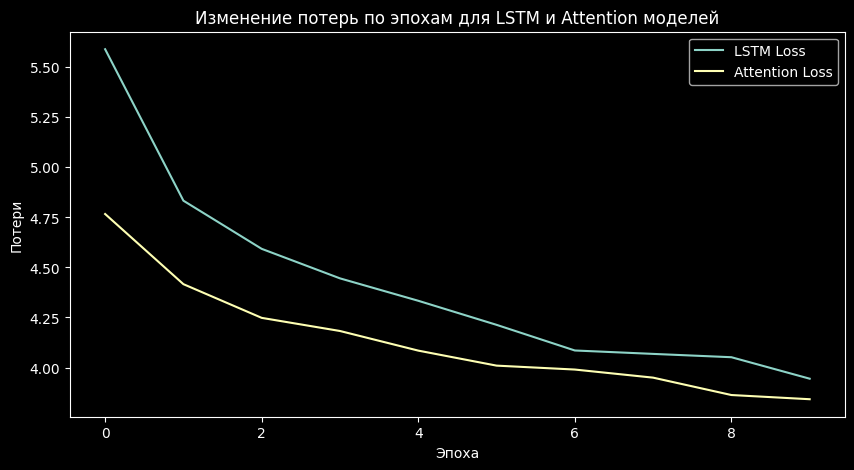

In [ ]:
# Построение графика потерь по эпохам для моделей
plt.figure(figsize=(10, 5))

# Потери для каждой модели
plt.plot(losses, label='LSTM Loss')
plt.plot(losses_attn, label='Attention Loss')

# Настройка графика
plt.title('Изменение потерь по эпохам для LSTM и Attention моделей')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

# Отображение графика
plt.show()

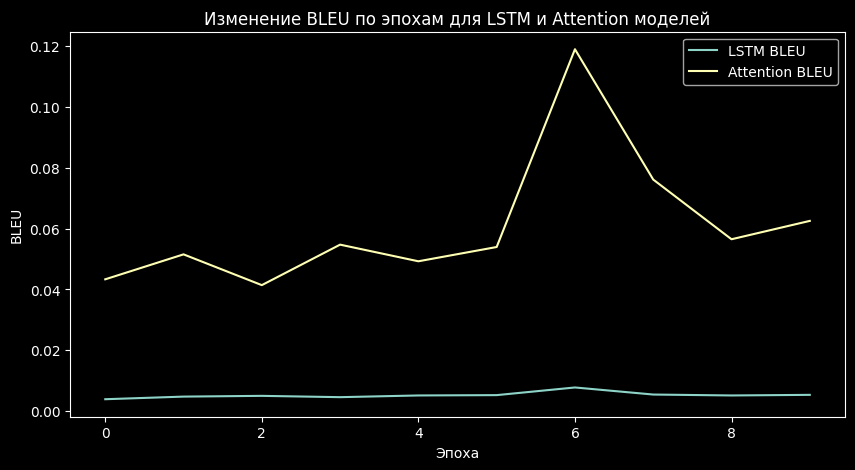

In [ ]:
# Построение графика BLEU-оценок по эпохам для двух моделей
plt.figure(figsize=(10, 5))

# BLEU-оценки для каждой модели
plt.plot(bleu, label='LSTM BLEU')
plt.plot(bleu_attn, label='Attention BLEU')

# Настройка графика
plt.title('Изменение BLEU по эпохам для LSTM и Attention моделей')
plt.xlabel('Эпоха')
plt.ylabel('BLEU')
plt.legend()

# Отображение графика
plt.show()

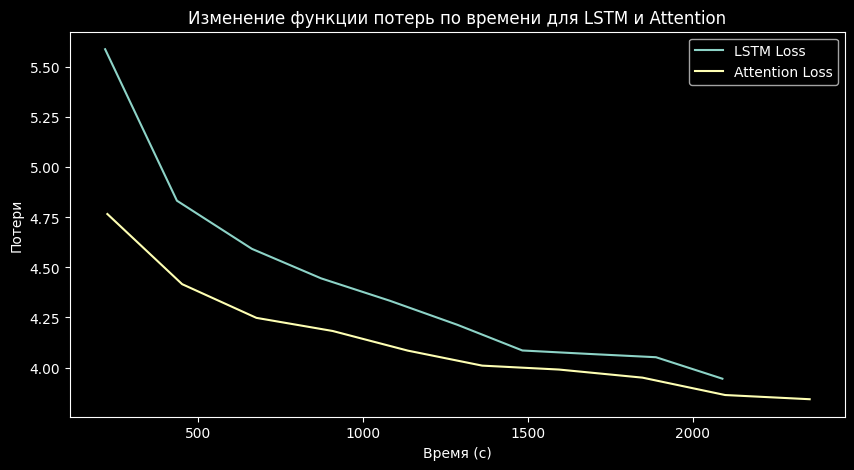

In [ ]:
# Построение графика потерь по времени для обеих моделей
plt.figure(figsize=(10, 5))

# Графики потерь для каждой модели
plt.plot(times, losses, label='LSTM Loss')
plt.plot(times_attn, losses_attn, label='Attention Loss')

# Настройка графика
plt.title('Изменение функции потерь по времени для LSTM и Attention')
plt.xlabel('Время (с)')
plt.ylabel('Потери')
plt.legend()

# Отображение графика
plt.show()

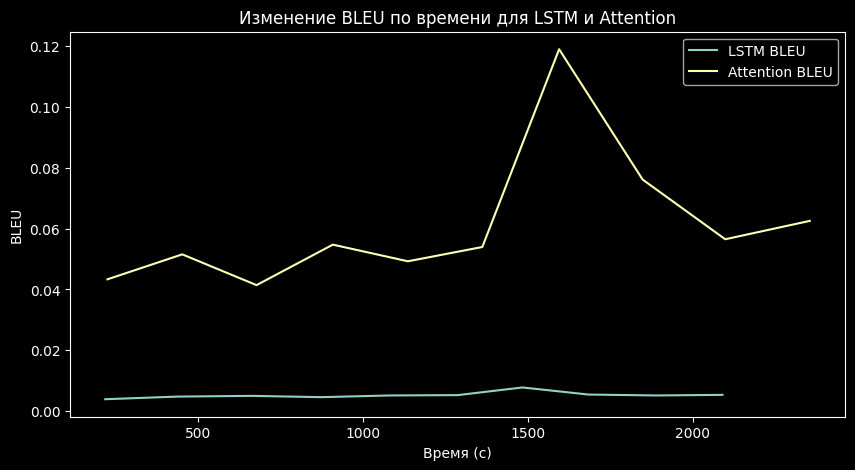

In [ ]:
# BLEU по времени для трёх моделей
plt.figure(figsize=(10, 5))

# Графики BLEU для каждой модели
plt.plot(times, bleu, label='LSTM BLEU')
plt.plot(times_attn, bleu_attn, label='Attention BLEU')

# Настройка графика
plt.title('Изменение BLEU по времени для LSTM и Attention')
plt.xlabel('Время (с)')
plt.ylabel('BLEU')
plt.legend()

# Отображение графика
plt.show()

Вывод:

Модель EncoderDecoder с LSTM имеет низкие значения метрики качества BLEU по сравнению с моделью EncoderDecoder с Attention.

В обеих моделях потери снижаются с увеличением итераций обучения.

Из двух обученных моделей выигрывает модель с Attention.